In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy
# import pycircstat
from collections import namedtuple
import pickle

# from models_cellcycle import *
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
import numpy as np
import numpyro
import numpyro.distributions as dist

# from params import 

from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from numpyro.optim import Adam
# from numpyro.distributions import constraints
from numpyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoNormal
# import init_to_value
from numpyro.infer import init_to_value, init_to_feasible

from numpyro.infer import MCMC, NUTS, Predictive, HMCGibbs, DiscreteHMCGibbs, SA, reparam
from numpyro.distributions import TruncatedNormal

In [3]:
def truncated_normal_model(num_observations, x=None):
    loc = numpyro.param("loc", 0.0)
    scale = numpyro.param("scale", 1.0, constraint=dist.constraints.positive)
    low = numpyro.param("low", -1.0)
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", TruncatedNormal(loc, scale, low=low), obs=x)
def guide(num_observations, x=None):
    pass

In [4]:
num_observations = 250
num_prior_samples = 100
PRIOR_RNG=jax.random.PRNGKey(0)

prior = Predictive(truncated_normal_model, num_samples=num_prior_samples)
prior_samples = prior(PRIOR_RNG, num_observations)

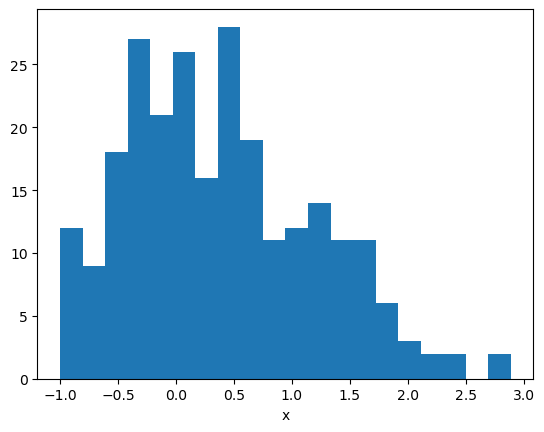

In [5]:
true_idx = 0
true_x = prior_samples["x"][true_idx]

plt.hist(true_x.copy(), bins=20)
plt.xlabel("x")
plt.show()

In [6]:
# find the MLE of the truncated normal using numpyro SVI
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam

optimizer = Adam(step_size=0.001)
svi = SVI(truncated_normal_model, guide, optimizer, loss=Trace_ELBO())
# Training loop
rng_key = random.PRNGKey(np.random.randint(0, 1000))
n_steps = 200

res=svi.run(rng_key, n_steps, num_observations, true_x)


100%|██████████| 200/200 [00:00<00:00, 456.32it/s, init loss: 284.8210, avg. loss [191-200]: 268.1505]


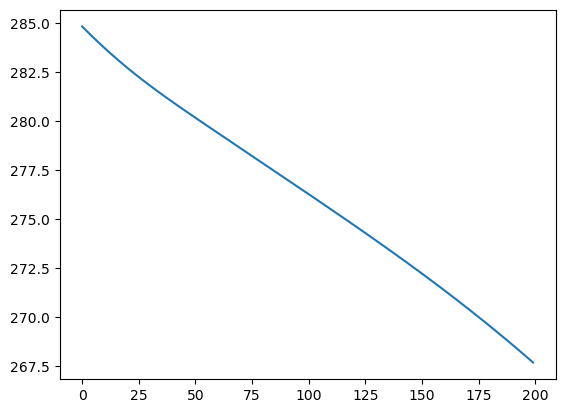

In [7]:
plt.plot(res.losses)

In [9]:
res.params

{'loc': Array(0.04781673, dtype=float32),
 'low': Array(-0.793221, dtype=float32),
 'scale': Array(1.0282264, dtype=float32)}